# Output parsers

Now, let's start working on the application logic itself. Let's use LLM to classify whether a job description suites an imaginary profile:

In [2]:
from langchain_google_vertexai import ChatVertexAI
llm = ChatVertexAI(model="gemini-1.5-flash-002")

job_description: str = ""
prompt_template = (
    "Given a job description, decide whether it suites a junior Java developer."
    "\nJOB DESCRIPTION:\n{job_description}\n"
)
result = llm.invoke(prompt_template.format(job_description=job_description))
print(result)

content='Please provide the job description. I need the text of the job description to determine if it is suitable for a junior Java developer.\n' additional_kwargs={} response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 19, 'candidates_token_count': 27, 'total_token_count': 46, 'prompt_tokens_details': [{'modality': 1, 'token_count': 19}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 27}], 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.08271982051708081} id='run-76945220-87e4-4e4e-a528-be9e222f8904-0' usage_metadata={'input_tokens': 19, 'output_tokens': 27, 'total_tokens': 46}


Put any relevant job description here:

In [3]:
job_description = """
SPS-Software Engineer (m/w/d) im Maschinenbau
Glaston Germany GmbH
Neuhausen-Hamberg
Feste Anstellung
Homeoffice möglich, Vollzeit
Erschienen: vor 1 Tag
Glaston Germany GmbH logo
SPS-Software Engineer (m/w/d) im Maschinenbau
Glaston Germany GmbH
slide number 1slide number 2slide number 3
Glaston ist eine internationale Marke mit weltweit führenden Unternehmen, die für zukunftsweisende Maschinen, Anlagen, Systeme und Dienstleistungen in der Bearbeitung von Architektur-, Fahrzeug- und Displayglas steht.

Mit unserer über 50-jährigen Erfahrung am Standort Glaston Germany GmbH in Neuhausen bei Pforzheim verbessern und sichern wir nachhaltig die Produktivität unserer Kunden bei der Fertigung von Architekturglas. Diesen Erfolg verdanken wir unseren motivierten und engagierten Mitarbeitenden und wurden so zu einem der führenden Anbieter von automatisierten und kundenspezifischen Anlagen.

Der Umgang mit Software liegt dir im Blut und du möchtest bei einem Hidden Champion durchstarten?
Dein Faible für Softwarelösungen und dein Herz für unterschiedliche Technologien sind ideale Voraussetzungen, um Maschinen wieder zu alter Stärke zu verhelfen?
Du hast einen ausgeprägten Servicegedanken und Spaß an der Arbeit mit Kunden?

Dann komm zu Glaston! Wir suchen ab sofort für unseren Bereich Service Upgrades Verstärkung!

SPS-SOFTWARE ENGINEER (M/W/D) IM MASCHINENBAU

Als SPS-Software Engineer (m/w/d) im Maschinenbau sind deine Aufgabengebiete:
Ausarbeitung und Weiterentwicklung von Kundenaufträgen und Upgrade-Konzepten
Selbstständige und termingerechte Bearbeitung von Kundenprojekten und Bereitstellung der notwendigen Dokumente
Unterstützung des Inbetriebnahme- und Servicepersonals im Haus und beim Kunden vor Ort
Diese Anforderungen musst du mitbringen:
Qualifizierte technische Ausbildung: Techniker, Studium oder vergleichbare Qualifikation
Mehrjährige Berufserfahrung im Serviceumfeld, idealerweise im Maschinen- und Anlagenbau
Umfangreiche Kenntnisse in verschiedenen SPS-Programmiersprachen (z.B. S7Classic, TIA, Simotion)
Bei uns profitierst du von folgenden Benefits:
Exzellente Rahmenbedingungen (z.B. attraktives Gehaltsmodell, flexible Arbeitszeiten mit Gleitzeit und Homeoffice-Möglichkeiten)
Attraktives Arbeitsumfeld in idyllisch-ländlicher Lage
Umfangreiche Mobilitätsförderung (z.B. Ladestation für Elektroautos)
Wellbeing am Arbeitsplatz
"""

And run it:

In [4]:
prompt_template_enum = (
    "Given a job description, decide whether it suites a junior Java developer."
    "\nJOB DESCRIPTION:\n{job_description}\n\nAnswer only YES or NO."
)
result = llm.invoke(prompt_template_enum.format(job_description=job_description))
print(result.content)

NO



Let's use an out-of-the-box parser provided by LangChain:

In [5]:
from enum import Enum
from langchain.output_parsers import EnumOutputParser
from langchain_core.messages import HumanMessage

class IsSuitableJobEnum(Enum):
    YES = "YES"
    NO = "NO"

parser = EnumOutputParser(enum=IsSuitableJobEnum)

assert parser.invoke("NO") == IsSuitableJobEnum.NO
assert parser.invoke("YES\n") == IsSuitableJobEnum.YES
assert parser.invoke(" YES \n") == IsSuitableJobEnum.YES
assert parser.invoke(HumanMessage(content=" YES \n")) == IsSuitableJobEnum.YES

In [6]:
chain = llm | parser
result = chain.invoke(prompt_template_enum.format(job_description=job_description))
print(result)

IsSuitableJobEnum.NO


Now we can re-run our graph:

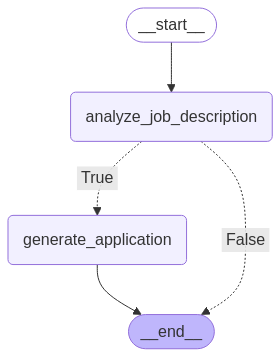

In [8]:
from typing_extensions import TypedDict
from langchain_core.runnables.config import RunnableConfig
from langgraph.graph import StateGraph, START, END

class JobApplicationState(TypedDict):
    job_description: str
    is_suitable: IsSuitableJobEnum
    application: str

analyze_chain = llm | parser


def analyze_job_description(state):
    job_description = state["job_description"]
    prompt = prompt_template_enum.format(job_description=job_description)
    result = analyze_chain.invoke(prompt)
    return {"is_suitable": result}


def is_suitable_condition(state: StateGraph):
    return state["is_suitable"] == IsSuitableJobEnum.YES


def generate_application(state):
    print("...generating application...")
    return {"application": "some_fake_application", "actions": ["action2"]}


builder = StateGraph(JobApplicationState)
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)
builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges(
    "analyze_job_description", is_suitable_condition,
     {True: "generate_application", False: END})
builder.add_edge("generate_application", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))